## Mesh & Skeleton 

In [2]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils, skeletonize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# setup the mesh meta to handle downloads and caching
mesh_dir = 'data/' # .h5 mesh files will be saved to this repo
seg_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v185/seg"
mm = trimesh_io.MeshMeta(cv_path=seg_source,
                         disk_cache_path=mesh_dir, 
                         cache_size=20)

soma_table_file = 'data/soma_valence_v185.csv'
soma_df = pd.read_csv(soma_table_file)

print(len(soma_df))
print(len(set(soma_df.pt_root_id.unique())))

# Convert pt_position strings to a list:
def position_string_to_array(pos_string):
    vals = pos_string[1:-1].split(' ')
    return [int(x) for x in vals if len(x) > 0]

soma_df['pt_position'] = soma_df['pt_position'].apply(position_string_to_array)
soma_df.head()

456
453


,id,cell_type,pt_position,pt_root_id,soma_x_nm,soma_y_nm,soma_z_nm
0,17,e,"[103860, 44385, 891]",648518346349540057,415440,415440,4154400
1,453,e,"[84054, 50604, 1424]",648518346349538466,336216,336216,3362160
2,35,e,"[103728, 54333, 304]",648518346349538711,414912,414912,4149120
3,74,e,"[51543, 57568, 155]",648518346349538715,206172,206172,2061720
4,231,e,"[77197, 61773, 428]",648518346349537038,308788,308788,3087880


#### Read mesh: seg_id = pt_root_id from soma_df

In [3]:
# seg_id = 648518346349531254
seg_id = 648518346349539103 # proofread neuron

# mesh_file = os.path.join(mesh_dir, str(seg_id)+'.h5')
# mesh = mm.mesh(mesh_file)

# download the mesh file if it not there
mesh = mm.mesh(seg_id = seg_id, remove_duplicate_vertices=True)
print(type(mesh))
print(mesh.n_vertices, mesh.n_faces)

Decoding Mesh Buffer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 5540.91it/s]


<class 'meshparty.trimesh_io.Mesh'>
872634 1744608


#### calculate skeleton

In [4]:
sk = skeletonize.skeletonize_mesh(mesh, invalidation_d=12000)
print(type(sk))
print(sk.vertices.shape)

C:\Users\dean\Documents\dev\Connectomics\OFS-EM-Connectomics\.venv\lib\site-packages\meshparty\skeletonize.py:622: RuntimeWarning: invalid value encountered in multiply
  target = np.nanargmax(root_ds * valid)


<class 'meshparty.skeleton.Skeleton'>
(13372, 3)


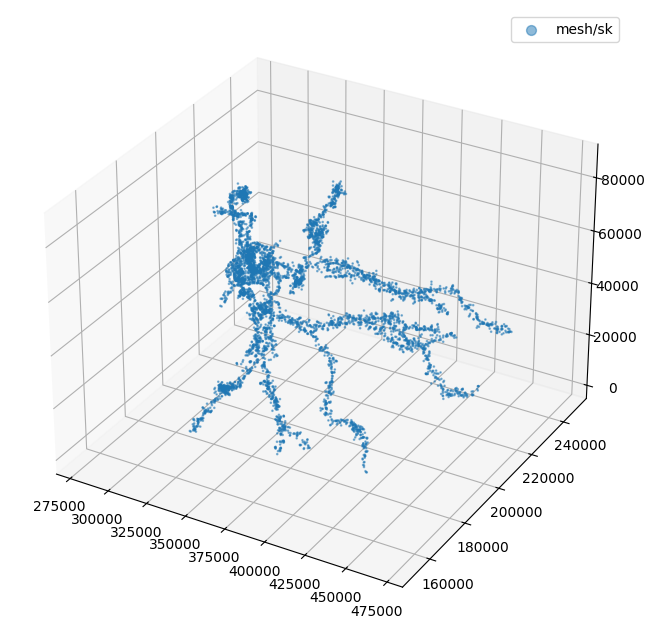

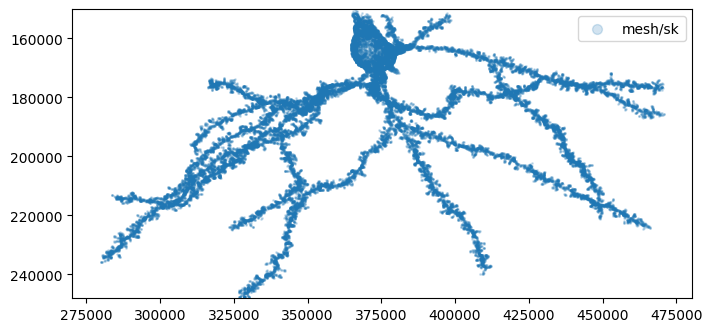

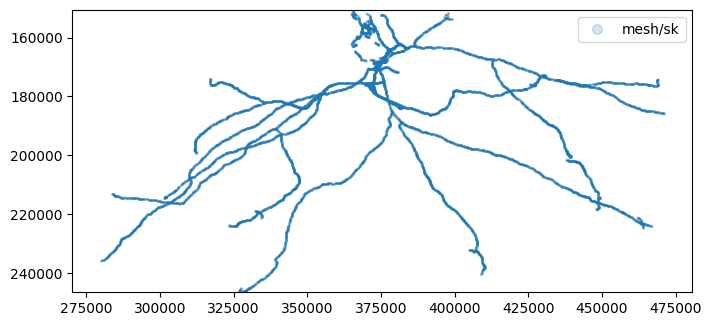

In [5]:
def plot_sk_or_mesh(sk_or_mesh, in_3d=True, sample=50, soma=None, syn_list=None, syn_size=1,
                    ex_syn=None, inh_syn=None):
    if in_3d:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')

        if soma is not None:
            ax.scatter3D(soma[0], soma[1], soma[2], c='red', s=200, alpha=1, label='soma')
        if syn_list is not None:
            ax.scatter3D(syn_list[:,0], syn_list[:,1], syn_list[:,2], c='purple', s=syn_size, alpha=.8, label='syn')
        if ex_syn is not None:
            ax.scatter3D(ex_syn[:,0], ex_syn[:,1], ex_syn[:,2], c='green', s=syn_size, alpha=.8, label='ex syn')
        if inh_syn is not None:
            ax.scatter3D(inh_syn[:,0], inh_syn[:,1], inh_syn[:,2], c='purple', s=syn_size, alpha=.8, label='in syn')
        
        ax.scatter3D(sk_or_mesh.vertices[::sample,0],
                     sk_or_mesh.vertices[::sample,1],
                     sk_or_mesh.vertices[::sample,2], s=0.8, alpha=.5, label='mesh/sk')
    else: 
        f,ax = plt.subplots(figsize=(8,8))
        ax.scatter(sk_or_mesh.vertices[::sample,0], sk_or_mesh.vertices[::sample,1], s=1, alpha=.2, label='mesh/sk')
    
        if soma is not None:
            ax.scatter(soma[0], soma[1], c='red', s=100, alpha=0.9, label='soma')
        if syn_list is not None:
            ax.scatter(syn_list[:,0], syn_list[:,1], c='purple', s=syn_size, alpha=.8, label='syn')
        if ex_syn is not None:
            ax.scatter(ex_syn[:,0], ex_syn[:,1], c='green', s=syn_size, alpha=.9, label='ex syn')
        if inh_syn is not None:
            ax.scatter(inh_syn[:,0], inh_syn[:,1], c='purple', s=syn_size, alpha=.9, label='inh syn')
            
        ax.set_aspect('equal')
        ax.set_ylim(np.max(sk_or_mesh.vertices[:,1]), np.min(sk_or_mesh.vertices[:,1]))

    lgnd = plt.legend(scatterpoints=1)
    for handle in lgnd.legend_handles:
        handle.set_sizes([50.0])
        
plot_sk_or_mesh(mesh, in_3d=True, sample=150)
plot_sk_or_mesh(mesh, in_3d=False, sample=20)
plot_sk_or_mesh(sk, in_3d=False, sample=1)

#### Add Soma & Synapses (this a local 3.2M synapses file exploration)
USing this tutorial: https://github.com/AllenInstitute/OFS-EM-Connectomics/tree/main?tab=readme-ov-file

In [8]:
synapse_table_file = 'data/pni_synapses_v185.csv'
synapse_df = pd.read_csv(synapse_table_file)
print(len(synapse_df))

# print(len(synapse_df.pre_root_id.unique()))
# print(len(synapse_df.post_root_id.unique()))

# neurons = set(synapse_df.pre_root_id.unique())
# neurons.update(set(synapse_df.post_root_id.unique()))
# print(len(neurons))

synapse_df.head()

3239275


,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
0,2715757,648518346349538285,648518346349536759,1103,280784,261896,40600,70050,65534,1015,70196,65474,1015,70104,65602,1015
1,12498,648518346342404863,648518346342414574,62,365832,292808,25800,91472,73196,645,91458,73202,645,91396,73216,645
2,12500,648518346342921567,648518346345323296,62,229144,155952,48080,57250,39028,1202,57286,38988,1202,57312,38966,1203
3,12517,648518346342796822,648518346349537255,955,398452,208560,50760,99538,52184,1276,99613,52140,1269,99550,52098,1276
4,12503,648518346342800412,648518346348190542,718,461868,245212,53560,115462,61350,1335,115467,61303,1339,115468,61296,1335


In [10]:
# soma_subgraph_df = pd.read_csv('../data/soma_subgraph_synapses_spines_v185.csv')
# print(len(soma_subgraph_df))
# print(len(set(soma_subgraph_df.post_root_id.unique())))
# print(len(set(soma_subgraph_df.pre_root_id.unique())))
# soma_subgraph_df.head()

Seg id: 648518346349539103
Getting all synapses
Synapses: 1977
Soma loc [voxel]: [93008, 40981, 1984]
Soma loc [nM]: [372032 163924  79360]


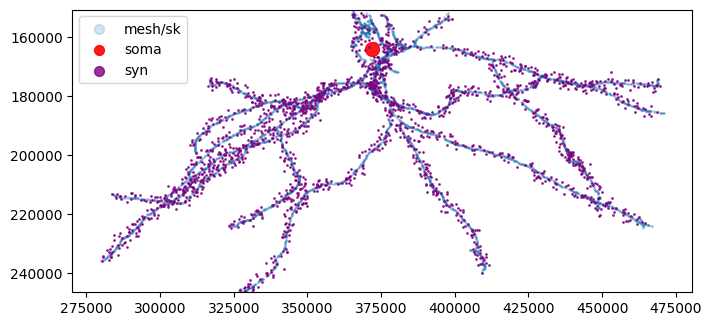

In [11]:
print(f'Seg id: {seg_id}')
take_all_syn = True
syn_size = 1 if take_all_syn else 20

if take_all_syn:
    print('Getting all synapses')
    cell_post_subgraph = synapse_df.query(f'post_root_id=={seg_id}')
else:
    print('Getting synapses from the "soma_subgraph_synapses_spines"')
    cell_post_subgraph = soma_subgraph_df.query(f'post_root_id=={seg_id}')

print(f'Synapses: {len(cell_post_subgraph)}')
syn_xyz = cell_post_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

# Handle Soma
soma_cell_df = soma_df.query(f'pt_root_id =={seg_id}')
if len(soma_cell_df) > 1:
    print('err?')

soma_voxel = soma_cell_df.iloc[0]['pt_position']
soma_xyz = np.array(soma_voxel) * np.array([4,4,40])
print(f'Soma loc [voxel]: {soma_voxel}')
print(f'Soma loc [nM]: {soma_xyz}')

# plot_sk_or_mesh(mesh, in_3d=False, sample=50, soma=soma_xyz, syn_list=syn_xyz, syn_size=syn_size)
plot_sk_or_mesh(sk, in_3d=False, sample=2, soma=soma_xyz, syn_list=syn_xyz, syn_size=syn_size)

### Look at synapse type based on pre-synaptic cell

Ex  Synapses: 11
Inh Synapses: 7


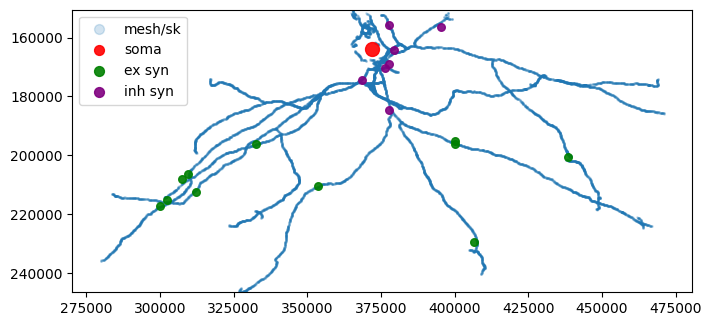

In [14]:
inh_root_ids = soma_df.query('cell_type=="i"')['pt_root_id'].values
ex_root_ids = soma_df.query('cell_type=="e"')['pt_root_id'].values

inh_syn_df = cell_post_subgraph.query('pre_root_id in @inh_root_ids')
ex_syn_df = cell_post_subgraph.query('pre_root_id in @ex_root_ids')

print(f'Ex  Synapses: {len(ex_syn_df)}')
print(f'Inh Synapses: {len(inh_syn_df)}')

inh_syn_xyz = inh_syn_df[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values
ex_syn_xyz = ex_syn_df[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

plot_sk_or_mesh(sk, in_3d=False, sample=1, soma=soma_xyz, ex_syn=ex_syn_xyz, inh_syn=inh_syn_xyz, syn_size=30)

#### (euclid) Distance from Soma [nano M]

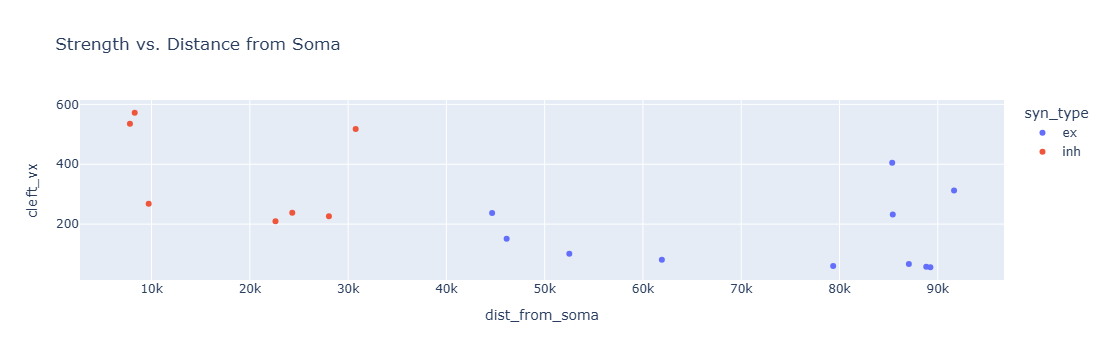

In [51]:
# TODO: not just euclid distance, but dikstra / over the tree

# cleft_vx: Size of the synaptic cleft in total voxel count. Generally proportional to surface area.
import plotly.express as px
pd.options.mode.copy_on_write = True

def synapse_dist_from_soma(syn):
    syn_xyz = np.array([syn['ctr_pt_x_nm'], syn['ctr_pt_y_nm'], syn['ctr_pt_z_nm']])
    return np.linalg.norm(soma_xyz - syn_xyz)

inh_syn_df['dist_from_soma'] = inh_syn_df.apply(synapse_dist_from_soma, axis=1).copy()
inh_syn_df['syn_type'] = 'inh'

ex_syn_df['dist_from_soma'] = ex_syn_df.apply(synapse_dist_from_soma, axis=1).copy()
ex_syn_df['syn_type'] = 'ex'

syn_df = pd.concat([ex_syn_df, inh_syn_df])
fig = px.scatter(syn_df, x="dist_from_soma", y="cleft_vx", color="syn_type",
                 title="Strength vs. Distance from Soma")
fig.show()